# PINN for flow around a cylinder
The Navier-Stokes equations are being solved for incompressible flow around a cylinder. These equations are a set of partial differential equations (PDEs) governing the motion of fluid substances. For a 2D incompressible, viscous flow, they can be written in the Cartesian coordinate system as follows:

## Continuity Equation:

The continuity equation represents the conservation of mass, stating that the mass entering a control volume must equal the mass exiting the volume, plus any change in mass within the volume. For an incompressible flow, it simplifies to:

$$ \nabla u = 0 $$

or, in a two-dimensional form:

$$
\begin{equation}
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
\tag{1}
\end{equation}
$$

where u and v are the velocity components in the x and y directions respectively.

## Momentum Equations:

The momentum equations represent the conservation of momentum. They are the result of applying Newton's second law (force equals the rate of change of momentum) to fluid motion. The Navier-Stokes equations include the effects of viscosity, which are modeled with a Laplacian operator. The momentum equations for an incompressible flow can be written as:

$$
\begin{equation}
\rho \left( \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} \right) = -\frac{\partial p}{\partial x} + \nu \nabla^2 u
\tag{2}
\end{equation}
$$
$$
\begin{equation}
\rho \left( \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} \right) = -\frac{\partial p}{\partial y} + \nu \nabla^2 v
\tag{3}
\end{equation}
$$

where:

ρ is the fluid density
u, v are the velocity components in the x and y directions, respectively
t is time
p is pressure
ν is the kinematic viscosity
∇² is the Laplacian operator, denoting the divergence of the gradient of a scalar field, here used to represent the diffusion of momentum (due to viscosity)
The pressure-Poisson equation is also used to enforce incompressibility:

$$
\begin{equation}
\nabla^2 p = -\rho \left( \left( \frac{\partial u}{\partial x} \right)^2 + 2 \frac{\partial u}{\partial y} \frac{\partial v}{\partial x} + \left( \frac{\partial v}{\partial y} \right)^2 \right)
\tag{4}
\end{equation}
$$
where
$$
\nabla^2 p = \frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2}
$$

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import math
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu"

In [2]:
xmax = 1.0
ymax = 1.0
tmax = 0.1

In [3]:
rho = 1
mu = .1

In [4]:
# Define the cylinder
center = [0.5, 0.5]  # center of the cylinder
radius = 0.1  # radius of the cylinder

In [5]:
def compute_grad(x, y):
        return torch.autograd.grad(x, y, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True, only_inputs=True)[0]

In [6]:
def get_collocation_points(xmin, xmax, ymin, ymax, tmin, tmax, center, radius, n):
    
    x = []
    y = []
    t = []

    h, k = center  # center of the circle

    while len(x) < n:  # generate Nf points
        # Generate random point in the rectangle
        x_point = xmin + (xmax - xmin) * random.random()
        y_point = ymin + (ymax - ymin) * random.random()
        t_point = tmin + (tmax - tmin) * random.random()
        
        # Check if point is outside the circle
        if (x_point - h) ** 2 + (y_point - k) ** 2 >= radius ** 2:
            x.append(x_point)
            y.append(y_point)
            t.append(t_point)
    return x, y, t

def get_boundary_points(xmin, xmax, tmin, tmax, n):
    
    x = []
    t = []

    while len(x) < n:  # generate Nb points
    # Generate random point in the rectangle
        x_point = xmin + (xmax - xmin) * random.random()
        t_point = tmin + (tmax - tmin) * random.random()
        
        x.append(x_point)
        t.append(t_point)

    return x, t

def get_cylinder_bc_points(center, radius, tmin, tmax, n):

    x_center, y_center = center
    x = []
    y = []
    t = []
    
    for _ in range(n):
        # Generate random angle and random radius
        rand_angle = 2 * math.pi * random.random()
        rand_radius = radius * math.sqrt(random.random())
        # Convert polar coordinates to cartesian
        x_point = x_center + rand_radius * math.cos(rand_angle)
        y_point = y_center + rand_radius * math.sin(rand_angle)
        t_point = tmin + (tmax - tmin) * random.random()

        # Append to the lists
        x.append(x_point)
        y.append(y_point)
        t.append(t_point)

    return x, y, t

In [7]:
def get_batch(Nf, Nc, Nb):

    xf, yf, tf = get_collocation_points(0, xmax, 0, ymax, 0, tmax, center, radius, Nf)
    xc, yc, tc = get_cylinder_bc_points(center, radius, 0, tmax, Nc)

    xb_left = np.zeros(int(Nb/4))
    yb_left, tb_left = get_boundary_points(0, ymax, 0, tmax, int(Nb/4))

    xb_right = np.ones(int(Nb/4))
    yb_right, tb_right = get_boundary_points(0, ymax, 0, tmax, int(Nb/4))

    xb_up, tb_up = get_boundary_points(0, xmax, 0, tmax, int(Nb/4))
    yb_up = np.ones(int(Nb/4))

    xb_down, tb_down = get_boundary_points(0, xmax, 0, tmax, int(Nb/4))
    yb_down = np.zeros(int(Nb/4))

    # Convert numpy arrays to PyTorch tensors
    xf_tensor = torch.tensor(xf, dtype=torch.float32, device=device, requires_grad=True)
    yf_tensor = torch.tensor(yf, dtype=torch.float32, device=device, requires_grad=True)
    tf_tensor = torch.tensor(tf, dtype=torch.float32, device=device, requires_grad=True)

    xc_tensor = torch.tensor(xc, dtype=torch.float32, device=device, requires_grad=True)
    yc_tensor = torch.tensor(yc, dtype=torch.float32, device=device, requires_grad=True)
    tc_tensor = torch.tensor(tc, dtype=torch.float32, device=device, requires_grad=True)

    xb_left_tensor = torch.tensor(xb_left, dtype=torch.float32, device=device, requires_grad=True)
    yb_left_tensor = torch.tensor(yb_left, dtype=torch.float32, device=device, requires_grad=True)
    tb_left_tensor = torch.tensor(tb_left, dtype=torch.float32, device=device, requires_grad=True)

    xb_right_tensor = torch.tensor(xb_right, dtype=torch.float32, device=device, requires_grad=True)
    yb_right_tensor = torch.tensor(yb_right, dtype=torch.float32, device=device, requires_grad=True)
    tb_right_tensor = torch.tensor(tb_right, dtype=torch.float32, device=device, requires_grad=True)

    xb_up_tensor = torch.tensor(xb_up, dtype=torch.float32, device=device, requires_grad=True)
    yb_up_tensor = torch.tensor(yb_up, dtype=torch.float32, device=device, requires_grad=True)
    tb_up_tensor = torch.tensor(tb_up, dtype=torch.float32, device=device, requires_grad=True)

    xb_down_tensor = torch.tensor(xb_down, dtype=torch.float32, device=device, requires_grad=True)
    yb_down_tensor = torch.tensor(yb_down, dtype=torch.float32, device=device, requires_grad=True)
    tb_down_tensor = torch.tensor(tb_down, dtype=torch.float32, device=device, requires_grad=True)

    return xf_tensor, yf_tensor, tf_tensor, xc_tensor, yc_tensor, tc_tensor, xb_left_tensor, yb_left_tensor, tb_left_tensor, xb_right_tensor, yb_right_tensor, tb_right_tensor, xb_up_tensor, yb_up_tensor, tb_up_tensor, xb_down_tensor, yb_down_tensor, tb_down_tensor

In [8]:
class PINN(nn.Module):

    def __init__(self, hidden_units):

        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        in_units = 3
        out_units = 3
        for units in hidden_units:
            layer = nn.Linear(in_units, units)
            nn.init.xavier_normal_(layer.weight)
            self.layers.append(layer)
            in_units = units
        output_layer = nn.Linear(in_units, out_units)
        nn.init.xavier_normal_(output_layer.weight)
        self.layers.append(output_layer)

    def forward(self, x, y, t):

        x = x.flatten()
        y = y.flatten()
        t = t.flatten()

        input = torch.stack([x, y, t], dim=-1)

        for layer in self.layers[:-1]:
            output = torch.tanh(layer(input))
            input = output
        output = self.layers[-1](input)
        u = output[:, 0]
        v = output[:, 1]
        p = output[:, 2]

        return u, v, p

    def mse_f(self, x, y, t):

        u, v, p = self(x, y, t)

        # Compute derivatives of u
        u_t = compute_grad(u, t)
        u_x = compute_grad(u, x)
        u_y = compute_grad(u, y)
        u_xx = compute_grad(u_x, x)
        u_yy = compute_grad(u_y, y)

        # Compute derivatives of v
        v_t = compute_grad(v, t)
        v_x = compute_grad(v, x)
        v_y = compute_grad(v, y)
        v_xx = compute_grad(v_x, x)
        v_yy = compute_grad(v_y, y)

        # Compute derivatives of p
        p_x = compute_grad(p, x)
        p_xx = compute_grad(p_x, x)
        p_y = compute_grad(p, y)
        p_yy = compute_grad(p_y, y)

        f1 = u_x + v_y
        f2 = rho * (u_t + u*u_x + v*u_y) + p_x - mu * (u_xx + u_yy)
        f3 = rho * (v_t + u*v_x + v*v_y + p_y - mu * (v_xx + v_yy))
        f4 = p_xx + p_yy + rho * (u_x**2 - 2*u_y*v_x - v_y**2)

        _mse = (1/4) *  (torch.mean(torch.square(f1)) + \
                        torch.mean(torch.square(f2)) + \
                        torch.mean(torch.square(f3)) + \
                        torch.mean(torch.square(f4)))

        return _mse
    
    def mse_ic(self):
        return
    
    def mse_cylinder_bc(self, x, y, t):

        u, v, p = self(x, y, t)

        _mse = torch.mean( torch.square(u) + torch.square(v) )

        return _mse
    
    def mse_left_bc(self, y, t):

        x = torch.zeros_like(y)
        u, v, p = self(x, y, t)

        _mse = torch.mean( torch.square(u - torch.ones_like(u)) + torch.square(v - torch.zeros_like(v)) )

        return _mse
    
    def mse_right_bc(self, y, t):

        x = torch.full_like(y, xmax)
        u, v, p = self(x, y, t)

        u_t = compute_grad(u, t)
        v_t = compute_grad(v, t)

        _mse = torch.mean( torch.square(u_t) + torch.square(v_t) )

        return _mse

    def mse_up_bc(self, x, t):

        y = torch.full_like(x, ymax)
        u, v, p = self(x, y, t)

        u_t = compute_grad(u, t)

        _mse = torch.mean( torch.square(u_t) + torch.square(v) )

        return _mse
    
    def mse_down_bc(self, x, t):

        y = torch.zeros_like(x)
        u, v, p = self(x, y, t)

        u_t = compute_grad(u, t)

        _mse = torch.mean( torch.square(u_t) + torch.square(v) )

        return _mse

    def mse_bc(self, yb_left, tb_left, yb_right, tb_right, xb_up, tb_up, xb_down, tb_down):

        _mse = (1/4) * (self.mse_left_bc(yb_left, tb_left) + self.mse_right_bc(yb_right, tb_right) + self.mse_up_bc(xb_up, tb_up) + self.mse_down_bc(xb_down, tb_down))

        return _mse

    def mse_data():
        # TODO
        return

    def loss(self, cf, cc, cb, xf, yf, tf, xc, yc, tc, xb_left, yb_left, tb_left, xb_right, yb_right, tb_right, xb_up, yb_up, tb_up, xb_down, yb_down, tb_down):
        # unused values only for debugging

        _mse_f = self.mse_f(xf, yf, tf)
        _mse_cylinder_bc = self.mse_cylinder_bc(xc, yc, tc)
        _mse_bc = self.mse_bc(yb_left, tb_left, yb_right, tb_right, xb_up, tb_up, xb_down, tb_down)

        _loss = cf * _mse_f + cc * _mse_cylinder_bc +  cb * _mse_bc

        return _loss, _mse_f, _mse_cylinder_bc, _mse_bc

    def set_training_params(self, cf, cc, cb, Nf, Nc, Nb):

        self.cf = cf
        self.cc = cc
        self.cb = cb 
        self.Nf = Nf
        self.Nc = Nc
        self.Nb = Nb

    def closure(self, loss_report=False):

        xf, yf, tf, xc, yc, tc, xb_left, yb_left, tb_left, xb_right, yb_right, tb_right, xb_up, yb_up, tb_up, xb_down, yb_down, tb_down = get_batch(self.Nf, self.Nc, self.Nb)
        _loss, _mse_f, _mse_cylinder_bc, _mse_bc = self.loss(self.cf, self.cc, self.cb, xf, yf, tf, xc, yc, tc, xb_left, yb_left, tb_left, xb_right, yb_right, tb_right, xb_up, yb_up, tb_up, xb_down, yb_down, tb_down)

        _loss.backward()

        if loss_report:
            return _loss, _mse_f, _mse_cylinder_bc, _mse_bc
        else:
            return _loss

    def train(self, epochs, optimizer, cf, cc, cb, Nf, Nc, Nb):

        self.set_training_params(cf, cc, cb, Nf, Nc, Nb)

        for epoch in range(epochs):
            optimizer.step(self.closure)
            if epoch % 10 == 0:
                _loss, _mse_f, _mse_cylinder_bc, _mse_bc = self.closure(loss_report=True)
                print(f'Epoch: {epoch},\tTotal loss: {_loss.item()},\tPDE loss: {_mse_f.item()},\tCylinder BC loss: {_mse_cylinder_bc.item()},\tBC loss: {_mse_bc.item()}')

In [9]:
# hidden_units = [32, 32, 32]
# hidden_units = [64, 64, 64, 64]
# hidden_units = [128, 128, 128, 128]
# hidden_units = [256, 256, 256, 256]
# hidden_units = [512, 512]
# hidden_units = [1024, 1024, 1024]
# hidden_units = [20, 40, 80, 100, 100, 80, 40, 20]
hidden_units = [128 for _ in range(10)]

pinn = PINN(hidden_units).to(device)

In [10]:
optimizer = torch.optim.Adam(pinn.parameters(), lr=0.001)
# optimizer = torch.optim.LBFGS(pinn.parameters())

epochs = 1000

cf = 0
cc = 0.5
cb = 0.5

Nf = 10000
Nc = 1000
Nb = 4000

pinn.train(epochs, optimizer, cf, cc, cb, Nf, Nc, Nb)

Epoch: 0,	Total loss: 3.3858237266540527,	PDE loss: 0.0015638892073184252,	Cylinder BC loss: 3.697942018508911,	BC loss: 3.0737054347991943
Epoch: 10,	Total loss: 2.2766871452331543,	PDE loss: 0.013345582410693169,	Cylinder BC loss: 2.5341780185699463,	BC loss: 2.019196033477783
Epoch: 20,	Total loss: 2.1498496532440186,	PDE loss: 0.00015510429511778057,	Cylinder BC loss: 4.040120601654053,	BC loss: 0.2595786154270172
Epoch: 30,	Total loss: 3.2248587608337402,	PDE loss: 1.7300219042226672e-05,	Cylinder BC loss: 4.064351558685303,	BC loss: 2.3853659629821777
Epoch: 40,	Total loss: 5.402345657348633,	PDE loss: 9.683823236628086e-07,	Cylinder BC loss: 5.964625358581543,	BC loss: 4.8400654792785645
Epoch: 50,	Total loss: 0.8979712724685669,	PDE loss: 1.9026500375218802e-09,	Cylinder BC loss: 1.5846333503723145,	BC loss: 0.21130919456481934
Epoch: 60,	Total loss: 6.361514568328857,	PDE loss: 8.77851347169667e-10,	Cylinder BC loss: 7.40784215927124,	BC loss: 5.315186977386475
Epoch: 70,	Tota

KeyboardInterrupt: 

In [ ]:
# Nf = 10000
# Nc = 1000
# Nb = 4000

# xf, yf, tf, xc, yc, tc, xb_left, yb_left, tb_left, xb_right, yb_right, tb_right, xb_up, yb_up, tb_up, xb_down, yb_down, tb_down = get_batch(Nf, Nc, Nb)

# xb = np.concatenate((xb_left, xb_right, xb_up, xb_down))
# yb = np.concatenate((yb_left, yb_right, yb_up, yb_down))
# tb = np.concatenate((tb_left, tb_right, tb_up, tb_down))

In [ ]:
# import plotly.graph_objects as go

# fig1 = go.Figure(
#     data = [
#             go.Scatter3d(
#                 x=xf,
#                 y=tf,
#                 z=yf,
#                 mode='markers',
#                 marker=dict(
#                     size=2,
#                     color="blue",  # set color to z values for better visual understanding
#                     colorscale='Viridis',  # choose a colorscale
#                     opacity=0.8),
#                 name="Collocation points",
#                 showlegend=True)])

# fig2 = go.Figure(
#     data = [
#             go.Scatter3d(
#                 x=xb,
#                 y=tb,
#                 z=yb,
#                 mode='markers',
#                 marker=dict(
#                     size=2,
#                     color="green",  # set color to z values for better visual understanding
#                     colorscale='Viridis',  # choose a colorscale
#                     opacity=0.8),
#                     name="Boundary points",
#                     showlegend=True),
#             go.Scatter3d(
#                 x=xc,
#                 y=tc,
#                 z=yc,
#                 mode='markers',
#                 marker=dict(
#                     size=2,
#                     color="red",  # set color to z values for better visual understanding
#                     colorscale='Viridis',  # choose a colorscale
#                     opacity=0.8),
#                 name="Cylinder boundary points",
#                 showlegend=True)])

# # Updating titles and labels
# for fig in [fig1, fig2]:
#     fig.update_layout(
#         scene=dict(
#             xaxis_title='x',
#             yaxis_title='t',
#             zaxis_title='y'
#         ),
#         width=700,
#         margin=dict(r=20, b=10, l=10, t=10))
#     # Show the plot
#     fig.show()

In [16]:
Nx = 100
Ny = 100

x_test = np.linspace(0, xmax, Nx)
y_test = np.linspace(0, ymax, Ny)
t_test = np.array([1])

x_test_grid, y_test_grid, t_test_grid = np.meshgrid(x_test, y_test, t_test)

# Evaluate the model at the grid points
x_test_tensor = torch.tensor(x_test_grid.reshape(-1, 1), dtype=torch.float32, device=device, requires_grad=True)
y_test_tensor = torch.tensor(y_test_grid.reshape(-1, 1), dtype=torch.float32, device=device, requires_grad=True)
t_test_tensor = torch.tensor(t_test_grid.reshape(-1, 1), dtype=torch.float32, device=device, requires_grad=True)

with torch.no_grad():  # Disable gradient calculation to save memory and computation
    u, v, p = pinn(x_test_tensor, y_test_tensor, t_test_tensor)

In [17]:
u = u.detach().cpu().numpy().reshape(x_test.shape[0], y_test.shape[0])
v = v.detach().cpu().numpy().reshape(x_test.shape[0], y_test.shape[0])
p = p.detach().cpu().numpy().reshape(x_test.shape[0], y_test.shape[0])

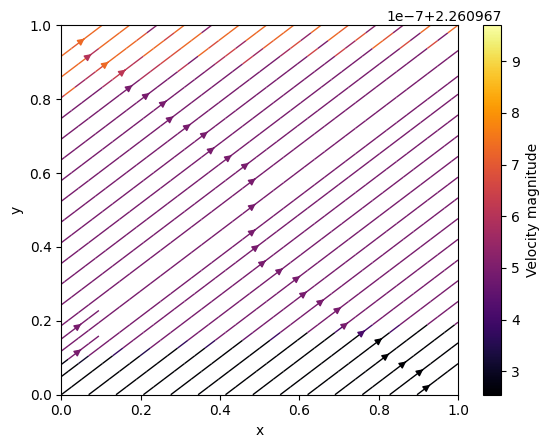

In [19]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig, ax = plt.subplots()

velocity_magnitude = np.sqrt(u**2 + v**2)

x_test_grid_2d, y_test_grid_2d = np.meshgrid(x_test, y_test)

strm = ax.streamplot(x_test_grid_2d, y_test_grid_2d, u, v, color=velocity_magnitude, linewidth=1, cmap=cm.inferno)

ax.set_xlim(0, 1)  # Set x-axis limits
ax.set_ylim(0, 1)  # Set y-axis limits
ax.set_xlabel("x")  # Set y-axis limits
ax.set_ylabel("y")  # Set y-axis limits

norm = mcolors.Normalize(vmin=np.min(velocity_magnitude), vmax=np.max(velocity_magnitude))
sm = plt.cm.ScalarMappable(cmap=cm.inferno, norm=norm)
sm.set_array([])

fig.colorbar(sm, ax=ax, label='Velocity magnitude')